In [865]:
import matplotlib.pyplot as plt
import numpy as np

input_dir = './data/'
filename = 'CARAS60 .ELH'
#filename = '32.ASC'
fs = 500                    # частота дискретизации, Гц
first_stim_start_time = 1   # начало первого стимула, с
period = 5                  # период следования стимулов, с
background_start_time = 5   # начало фоновой засветки, с
background_duration = 10    # длительность фоновой засветки, с
sign = 1                    # полярность {1:'+', -1:'-'}
low_cutoff = 0.2            # частота среза highpass фильтра, Гц
# начало первого импульса после фоновой засветки
after_background_start_time = first_stim_start_time + ((background_start_time + background_duration - first_stim_start_time) // period + 1) * period

In [866]:
with open(input_dir + filename, 'r', encoding='utf-8') as file:
    file.readline()
    line = file.readline()
    while line and line[0] == '"':
        line = file.readline()
    signal = [sign * float('0' if line == '.\n' else line)]
    for line in file:
        signal.append(sign * float('0' if line == '.\n' else line))
    signal = np.array(signal)

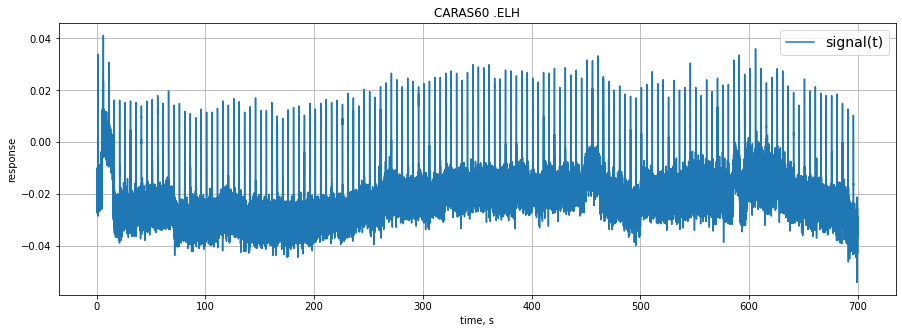

In [867]:
n = signal.size
t = np.linspace(0, (n - 1) / fs, n)
fig, ax = plt.subplots()
ax.plot(t, signal, label='signal(t)')
fig.set_figwidth(15)
fig.set_figheight(5)
ax.set_xlabel('time, s')
ax.set_ylabel('response')
ax.set_title(filename)
ax.legend(prop={"size": 14})
ax.grid()

In [868]:
# Добавление префикса длиной 1 / low_cutoff секунд, для того чтобы к 0 с завершился переходный процесс highpass фильтра
start_time = -int(1 / low_cutoff)
end_time = int((n - 1) / fs)
prefix = np.full(-start_time * fs, signal[0])
signal = np.concatenate((prefix, signal))
# Удаление ступеньки, для того чтобы избежать переходного процесса фильтра после нее и измерить высоту первого после нее стимула
begin = (background_start_time - start_time) * fs
end = (after_background_start_time - start_time) * fs - (after_background_start_time - background_start_time - background_duration) * fs // 2
backup = np.array(signal[begin:end])
signal[begin:end] = signal[end]
n = signal.size
t = np.linspace(start_time, end_time, n)

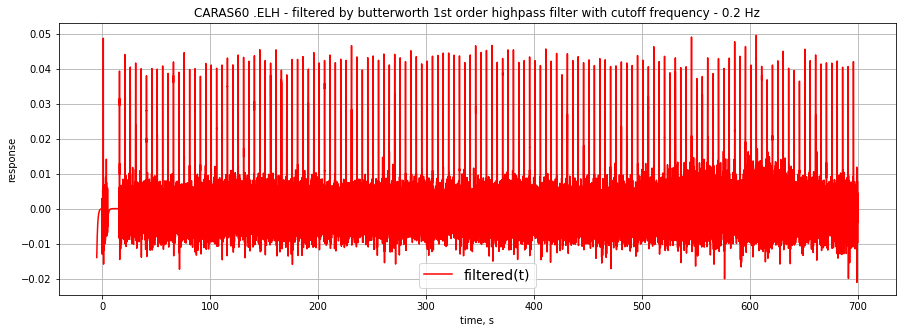

In [869]:
from scipy.signal import butter, lfilter

nyq = 0.5 * fs
b, a = butter(1, low_cutoff / nyq, btype='highpass', analog=False)
filtered = lfilter(b, a, signal)

fig, ax = plt.subplots()
ax.plot(t, filtered, 'r', label='filtered(t)')
fig.set_figwidth(15)
fig.set_figheight(5)
ax.set_xlabel('time, s')
ax.set_ylabel('response')
ax.set_title(f'{filename} - filtered by butterworth 1st order highpass filter with cutoff frequency - {low_cutoff} Hz')
ax.legend(prop={"size": 14})
ax.grid()

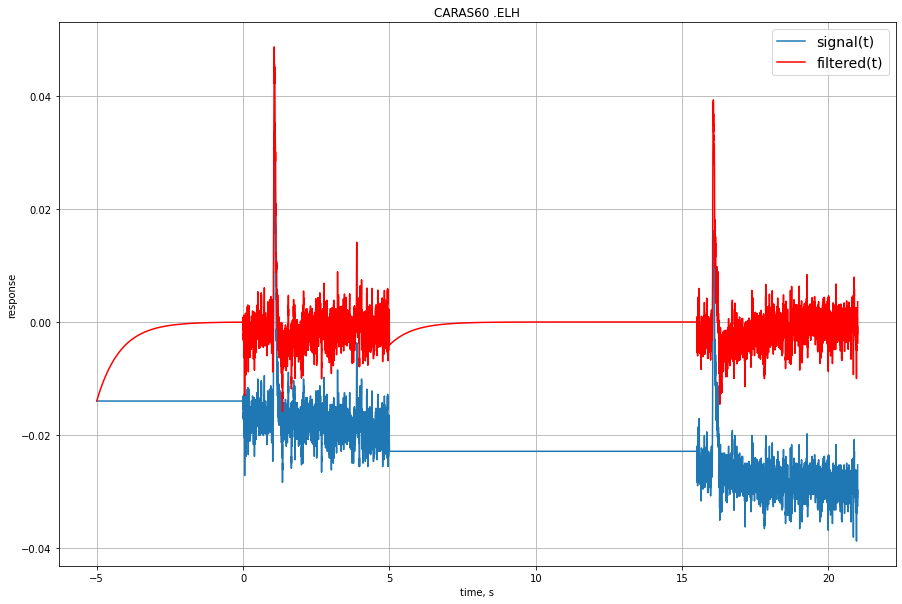

In [870]:
fig, ax = plt.subplots()
end = (after_background_start_time - start_time) * fs + period * fs
ax.plot(t[:end], signal[:end], label='signal(t)')
ax.plot(t[:end], filtered[:end], 'r', label='filtered(t)')
fig.set_figwidth(15)
fig.set_figheight(10)
ax.set_xlabel('time, s')
ax.set_ylabel('response')
ax.set_title(f'{filename}')
ax.legend(prop={"size": 14})
ax.grid()

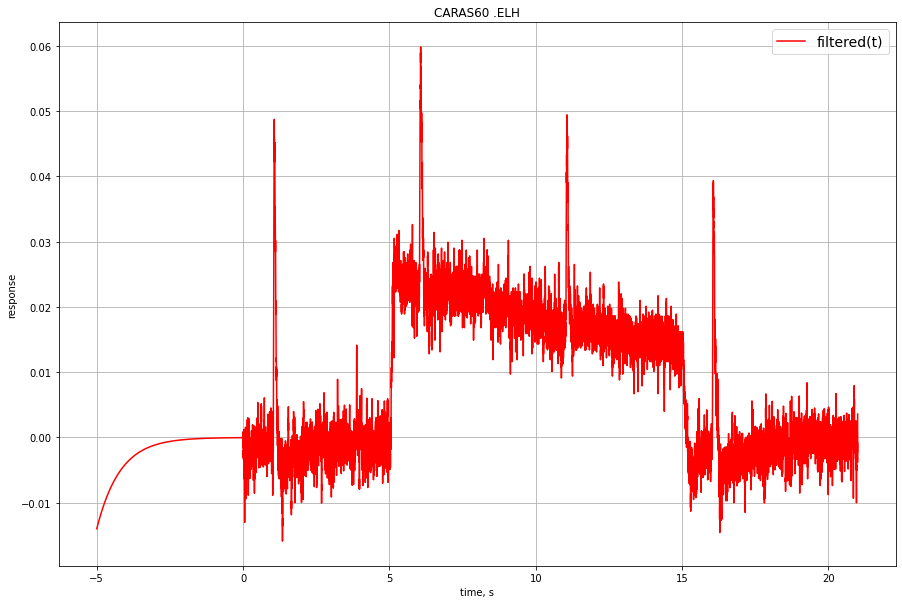

In [871]:
# Возврат ступеньки, смещенной к нулю, в отфильтрованный сигнал, просто чтобы ее нарисовать
begin = (background_start_time - start_time) * fs
end = (after_background_start_time - start_time) * fs - (after_background_start_time - background_start_time - background_duration) * fs // 2
filtered[begin:end] = backup - backup[0]


fig, ax = plt.subplots()
end = (after_background_start_time - start_time) * fs + period * fs
ax.plot(t[:end], filtered[:end], 'r', label='filtered(t)')
fig.set_figwidth(15)
fig.set_figheight(10)
ax.set_xlabel('time, s')
ax.set_ylabel('response')
ax.set_title(f'{filename}')
ax.legend(prop={"size": 14})
ax.grid()

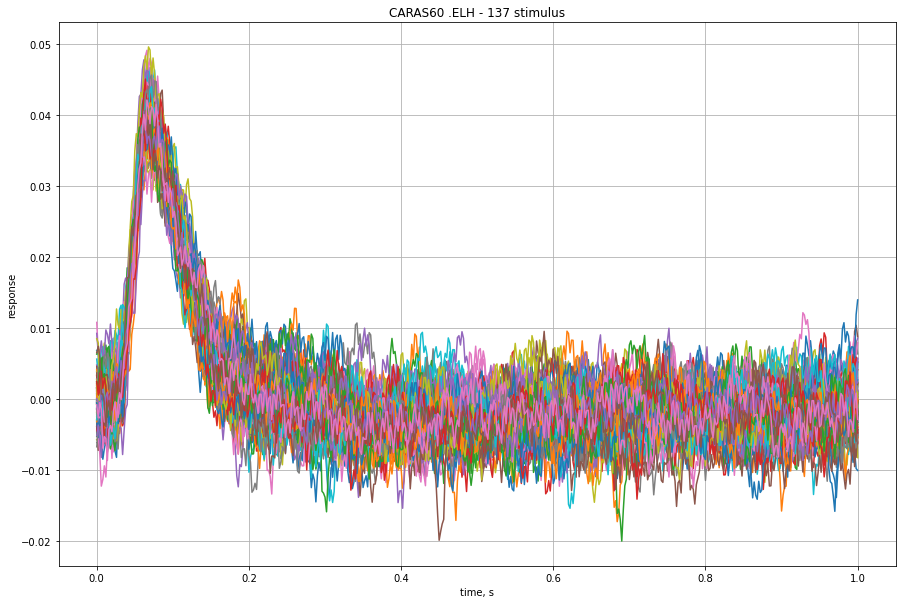

In [872]:
stims_cnt = (end_time - after_background_start_time) // period + 1
stims = []
for i in range(stims_cnt):
    begin = (after_background_start_time - start_time + period * i) * fs
    end = begin + fs
    stims.append(filtered[begin:end + 1])
temp_t = np.linspace(0, 1, fs + 1)
fig, ax = plt.subplots()
for stim in stims:
    ax.plot(temp_t, stim)
fig.set_figwidth(15)
fig.set_figheight(10)
ax.set_xlabel('time, s')
ax.set_ylabel('response')
ax.set_title(f'{filename} - {stims_cnt} stimulus')
ax.grid()

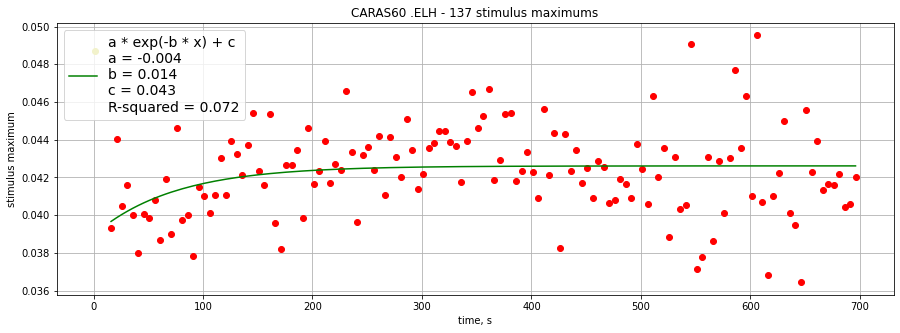

In [873]:
from scipy import stats, optimize

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

maximums = np.array([stim.max() for stim in stims])
temp_x = np.linspace(after_background_start_time, after_background_start_time + (stims_cnt - 1) * period, stims_cnt)
popt, pcov = optimize.curve_fit(func, temp_x, maximums, [-0.05, 0.01, 0.05])
fit = func(temp_x, *popt)
rvalue = stats.linregress(maximums, fit).rvalue

fig, ax = plt.subplots()
ax.plot(temp_x, maximums, 'ro')
begin = (first_stim_start_time - start_time) * fs
end = begin + fs
ax.plot(first_stim_start_time, filtered[begin: end].max(), 'yo')
ax.plot(temp_x, fit, 'g', label=f'a * exp(-b * x) + c\n'
                           f'a = {popt[0]:.3f}\n'
                           f'b = {popt[1]:.3f}\n'
                           f'c = {popt[2]:.3f}\n'
                           f'R-squared = {rvalue ** 2:.3f}')
fig.set_figwidth(15)
fig.set_figheight(5)
ax.set_xlabel('time, s')
ax.set_ylabel('stimulus maximum')
ax.set_title(f'{filename} - {stims_cnt} stimulus maximums')
ax.legend(prop={"size": 14})
ax.grid()

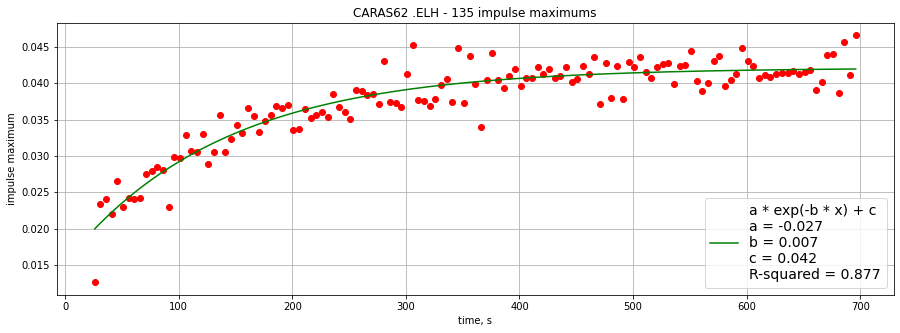

In [11]:
from scipy import stats, optimize

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

maximums = np.array([impulse.max() for impulse in impulses])
temp_x = np.linspace(after_background_start_time, after_background_start_time + (impulses_cnt - 1) * period, impulses_cnt)
popt, pcov = optimize.curve_fit(func, temp_x, maximums, [-0.05, 0.01, 0.05])
fit = func(temp_x, *popt)
rvalue = stats.linregress(maximums, fit).rvalue

fig, ax = plt.subplots()
ax.plot(temp_x, maximums, 'ro')
ax.plot(temp_x, fit, 'g', label=f'a * exp(-b * x) + c\n'
                           f'a = {popt[0]:.3f}\n'
                           f'b = {popt[1]:.3f}\n'
                           f'c = {popt[2]:.3f}\n'
                           f'R-squared = {rvalue ** 2:.3f}')
fig.set_figwidth(15)
fig.set_figheight(5)
ax.set_xlabel('time, s')
ax.set_ylabel('impulse maximum')
ax.set_title(f'{filename} - {impulses_cnt} impulse maximums')
ax.legend(prop={"size": 14})
ax.grid()